In [1]:
%matplotlib inline

# Distracted Drivers

### TODO
1. analyze data, understand structure
2. prepare validation set
3. prepare sample
4. finetune and train VGG16 on the dataset
5. Validate predictions
5. prepare output format and submit

The 10 classes to predict are:

```
c0: normal driving
c1: texting - right
c2: talking on the phone - right
c3: texting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger
```

## Prepare validation set

In [3]:
!cd data/state-farm-distracted-driver-detection
!mkdir valid
!mkdir sample
!mkdir -p sample/train
!mkdir -p sample/valid

In [7]:
!pwd

/home/ostap/courses/deeplearning1/nbs


In [2]:
import glob
import numpy as np
import shutil
import os

In [94]:
DATA_PATH = "/home/ostap/courses/deeplearning1/nbs/data/state-farm-distracted-driver-detection/"
_TRAIN = "train/"
_VALID = "valid/"
_TEST = "test/"

In [12]:
# for each folder c0..9
# choose 200 random pics from category and put in validation folder
for i in range(10):
    cat_dir = DATA_PATH + _TRAIN + "c" + str(i) + "/"
    valid_dir = DATA_PATH + _VALID + "c" + str(i) + "/"
    os.mkdir(valid_dir)
    cat_i = glob.glob(cat_dir + "*.jpg")
    cat_perm_200 = np.random.permutation(cat_i)[:200]
    for f in cat_perm_200:
        shutil.move(f, valid_dir)

## Prepare Sample Set

In [9]:
SAMPLE_PATH = DATA_PATH + "sample/"

Let's sample on 100 per category and 50 in validation.

In [15]:
# for each folder c0..9
# let's sample on 100 per category and 50 in validation.
for i in range(10):
    train_dir = DATA_PATH + _TRAIN + "c" + str(i) + "/"
    valid_dir = DATA_PATH + _VALID + "c" + str(i) + "/"
    sample_train_dir = SAMPLE_PATH + _TRAIN + "c" + str(i) + "/"
    sample_valid_dir = SAMPLE_PATH + _VALID + "c" + str(i) + "/"    
    os.mkdir(sample_train_dir)    
    os.mkdir(sample_valid_dir)
    
    train_i = glob.glob(train_dir + "*.jpg")
    train_perm_100 = np.random.permutation(train_i)[:100]
    valid_i = glob.glob(valid_dir + "*.jpg")
    valid_perm_50 = np.random.permutation(valid_i)[:50]
    
    for f in train_perm_100:
        shutil.copy(f, sample_train_dir)
    for f in valid_perm_50:
        shutil.copy(f, sample_valid_dir)        

In [37]:
#get 100 files for test    
sample_test_dir = SAMPLE_PATH + _TEST + "unknown/"
os.mkdir(sample_test_dir)

test = glob.glob(DATA_PATH + "test/*.jpg")
test_100 = np.random.permutation(test)[:100]

for f in test_100:
    shutil.copy(f, sample_test_dir)

## Finetune and Train VGG16 Model

In [6]:
from vgg16 import Vgg16

In [80]:
path = DATA_PATH

In [81]:
vgg = Vgg16()

In [82]:
batch_size = 64
train_batches = vgg.get_batches(path + _TRAIN, batch_size=batch_size) # default batch_size = 8
val_batches = vgg.get_batches(path + _VALID, batch_size=batch_size)

Found 20424 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [83]:
vgg.finetune(train_batches)

In [84]:
vgg.model.load_weights(DATA_PATH + "results/full_e02.h5")

In [72]:
epoch_id = 1

In [91]:
for i in range(10):
    vgg.fit(train_batches, val_batches, nb_epoch=1)
    epoch_id = epoch_id + 1 # if we re-run this script, i still wanna have power over the ID
    vgg.model.save_weights(DATA_PATH + ("results/full_e%02d.h5" % epoch_id))

Epoch 1/1
20424/20424 [==============================] - 505s - loss: 1.0602 - acc: 0.7118 - val_loss: 0.2280 - val_acc: 0.9295
Epoch 1/1
20424/20424 [==============================] - 505s - loss: 1.0015 - acc: 0.7295 - val_loss: 0.2882 - val_acc: 0.9190
Epoch 1/1
20424/20424 [==============================] - 506s - loss: 0.9259 - acc: 0.7351 - val_loss: 0.2092 - val_acc: 0.9440
Epoch 1/1
20424/20424 [==============================] - 506s - loss: 0.8976 - acc: 0.7384 - val_loss: 0.1887 - val_acc: 0.9435
Epoch 1/1
20424/20424 [==============================] - 506s - loss: 0.8764 - acc: 0.7472 - val_loss: 0.2198 - val_acc: 0.9435
Epoch 1/1
20424/20424 [==============================] - 506s - loss: 0.9112 - acc: 0.7408 - val_loss: 0.3344 - val_acc: 0.8970
Epoch 1/1
20424/20424 [==============================] - 506s - loss: 0.8908 - acc: 0.7467 - val_loss: 0.2105 - val_acc: 0.9380
Epoch 1/1
20424/20424 [==============================] - 506s - loss: 0.8779 - acc: 0.7503 - val_loss: 0

In [92]:
test_batches, predictions = vgg.test(path + _VALID)

Found 2000 images belonging to 10 classes.


In [58]:
import utils; reload(utils)
from utils import plots, categories_to_onehot, plot_confusion_matrix

In [88]:
# labels in format [0, 1, 3, 3, 2, 1, 3] <-- the ID of the category. Length = number of samples.
result_labels = np.argmax(predictions, axis=1)
expected_labels = test_batches.classes

# arrays in onehot format [[1 0 0 0], [0 1 0 0], [0 0 0 1], ...]
# predictions # resulting predictions from the model
# expected_predictions = categories_to_onehot(test_batches.classes)

In [89]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, result_labels)

[[169  16   0   0   2   1   6   1   1   4]
 [  0 198   0   0   0   0   1   0   1   0]
 [  0   0 190   1   0   0   6   0   3   0]
 [  3   8   1 177   5   0   5   0   0   1]
 [  2   1   1   2 190   0   1   1   2   0]
 [  2   2   0   0   0 193   1   1   0   1]
 [  0   5   0   1   0   0 193   0   1   0]
 [  1   3   0   0   1   0   0 193   1   1]
 [  1  10   3   0   3   0   6   9 164   4]
 [  6   8   2   1   2   2   1   0   3 175]]


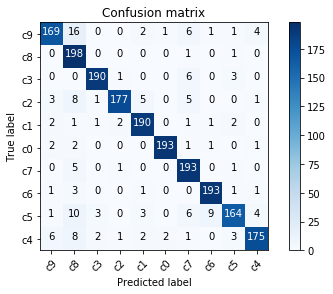

In [90]:
plot_confusion_matrix(cm, test_batches.class_indices)

[ 0.11  0.02  0.    0.    0.13  0.03  0.03  0.03  0.34  0.31]


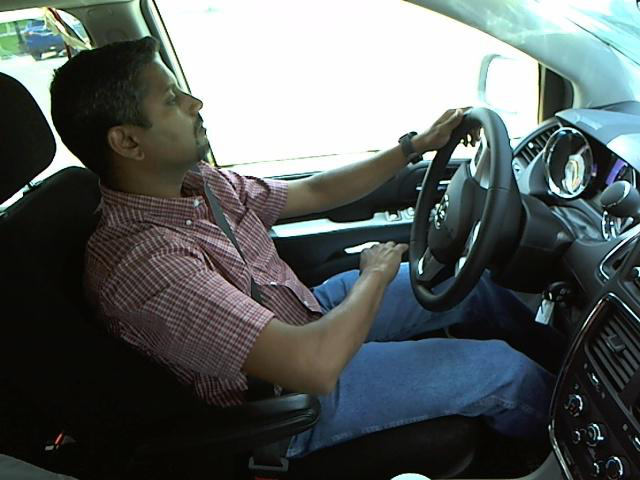

In [64]:
test_pred = 10
print np.round(predictions[test_pred],2)
Image.open(SAMPLE_VALID + test_batches.filenames[test_pred])

## Prepare Results for Kaggle

In [96]:
test_batches, predictions = vgg.test(path + _TEST)

Found 79726 images belonging to 1 classes.


In [97]:
filenames = test_batches.filenames

In [98]:
#Save our test results arrays so we can use them again later
utils.save_array(path + 'results/' + '10-epoch-predictions.dat', predictions)
utils.save_array(path + 'results/' + '10-epoch-filenames.dat', filenames)

In [106]:
distracted_driver = predictions.clip(min=0.02, max=0.95)

In [103]:
ids = map(lambda f: f[8:], filenames)

In [119]:
ids = np.array([ids])

In [120]:
print ids.T.shape
print distracted_driver.shape

(79726, 1)
(79726, 10)


In [123]:
submission = np.concatenate([ids.T,distracted_driver], axis=1)

In [127]:
submission_file_name = 'submission01-10epoch-clip.csv'
np.savetxt(path + 'results/' + submission_file_name, submission, fmt='%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s', header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9', comments='')